# 10k datapoint社交媒体行业级分析


## Chunk 0 — Import & Load

目的：导包、读取数据、看前几行，确认列名。



In [1]:
# Chunk 0 — Import & Load (updated for more models)

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    silhouette_score,
)

from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegression

# 尝试导入 XGBoost
try:
    from xgboost import XGBClassifier
    XGB_OK = True
except Exception:
    XGB_OK = False

# 尝试导入 CatBoost
try:
    from CatBoost import CatBoostClassifier  # 如果报错，再用小写 catboost
    CATBOOST_OK = True
except Exception:
    try:
        from catboost import CatBoostClassifier
        CATBOOST_OK = True
    except Exception:
        CATBOOST_OK = False

# 尝试导入 LightGBM
try:
    from lightgbm import LGBMClassifier
    LGBM_OK = True
except Exception:
    LGBM_OK = False

plt.style.use("default")
sns.set_theme()

# 读取数据
file_path = "social_media_engagement_data.xlsx"
df_raw = pd.read_excel(file_path)

print("[INFO] Loaded shape:", df_raw.shape)
print("[INFO] Columns:", list(df_raw.columns))
df_raw.head()


[INFO] Loaded shape: (100000, 18)
[INFO] Columns: ['Platform', 'Post ID', 'Post Type', 'Post Content', 'Post Timestamp', 'Likes', 'Comments', 'Shares', 'Impressions', 'Reach', 'Engagement Rate', 'Audience Age', 'Audience Gender', 'Audience Location', 'Audience Interests', 'Campaign ID', 'Sentiment', 'Influencer ID']


,Platform,Post ID,Post Type,Post Content,Post Timestamp,Likes,Comments,Shares,Impressions,Reach,Engagement Rate,Audience Age,Audience Gender,Audience Location,Audience Interests,Campaign ID,Sentiment,Influencer ID
0,LinkedIn,d49dadb4-fc1e-4775-88ad-d60b75cf5123,Video,Want that according same wish.,2021-04-23 08:19:49.255,415,77,85,2619,1842,31.32,29,Other,United Kingdom,respond,NaN,Negative,NaN
1,Instagram,16ce29c5-2dc7-478f-9814-a86754f3ce8b,Video,Increase fast partner south.,2023-07-30 06:40:06.356,908,125,85,1223,3884,28.78,48,Male,Greece,population,NaN,Neutral,NaN
2,Instagram,6a6cc741-72f4-4111-95a0-c5ee04a175a8,Video,Lawyer behavior born window couple sister.,2021-12-05 03:56:53.212,412,419,58,2165,849,104.71,55,Male,United States Virgin Islands,himself,NaN,Neutral,NaN
3,Twitter,0b5a3e70-c556-43cb-ad4f-a1d0003348bc,Image,Street great decade must.,2021-09-28 20:39:00.228,667,153,29,7191,3519,24.13,54,Other,Zambia,safe,NaN,NaN,NaN
4,Facebook,a7d3e958-e2fe-411e-a24a-b96e821fc050,Link,At clear meeting with reason ground continue c...,2023-02-27 17:51:21.425,659,215,34,3312,2032,44.69,33,Other,Afghanistan,well,6052b8d2-3403-4447-b0b4-c5ce20e6c8d0,NaN,NaN


## Chunk 1 — Basic Cleaning & Description

目的：规范列名、处理奇怪空格、选关键列、看数据健康情况。


In [2]:
# Chunk 1 — Load & Clean (exact same logic as teammate), final df is `df`


pd.set_option("display.max_columns", 100)

# 1. Load raw data
file_path = "social_media_engagement_data.xlsx"  # 修改成你当前数据文件名
df_raw = pd.read_excel(file_path)

print("🔍 Raw shape:", df_raw.shape)
print("🔍 Raw columns:", df_raw.columns.tolist())
display(df_raw.head(5))


def clean_social_media_data_exact(df):
    """
    Cleaning rules (matched to teammate's version):

    1. Drop duplicates.
    2. Drop fully empty rows.
    3. Strip spaces from column names.
    4. Convert ['Reach','Impressions','Likes','Comments','Shares','Engagement Rate'] to numeric.
    5. Keep rows where ALL these numeric columns are >= 0.
    6. If both exist: keep only Impressions >= Reach.
    7. If Reach exists: keep only Reach >= Likes/Comments/Shares.
    8. Engagement Rate check:
       - If many values > 1, treat as percentage and divide by 100.
       - Keep only Engagement Rate <= 1.
    9. Recompute:
       - Total_Engagement = Likes + Comments + Shares
       - If Reach exists: Engagement Rate = Total_Engagement / Reach
    10. Remove extreme ER outliers above 99.9% quantile.
    11. Drop rows with missing Engagement Rate.
    """

    df = df.copy()
    print("\n[Clean] Initial rows:", len(df))

    # 1) 去重
    df.drop_duplicates(inplace=True)

    # 2) 去掉全空行
    df.dropna(how="all", inplace=True)

    # 3) 去掉列名中的空格
    df.columns = df.columns.str.strip()

    # 4) 转成数值
    numeric_cols = ["Reach", "Impressions", "Likes", "Comments", "Shares", "Engagement Rate"]
    for col in numeric_cols:
        if col in df.columns:
            df[col] = pd.to_numeric(df[col], errors="coerce")

    # 5) 所有这些数值必须 >= 0
    existing_num = [c for c in numeric_cols if c in df.columns]
    if existing_num:
        df = df[(df[existing_num] >= 0).all(axis=1)]

    # 6) Impressions ≥ Reach
    if "Impressions" in df.columns and "Reach" in df.columns:
        df = df[df["Impressions"] >= df["Reach"]]

    # 7) Reach ≥ Likes/Comments/Shares
    if "Reach" in df.columns:
        for col in ["Likes", "Comments", "Shares"]:
            if col in df.columns:
                df = df[df[col] <= df["Reach"]]

    # 8) Engagement Rate 检查（基于原始列）
    if "Engagement Rate" in df.columns:
        er = df["Engagement Rate"]

        # 如果超过 20% 的值 > 1，认为是百分比，转成 0-1
        if (er > 1).mean() > 0.2:
            print("⚠️ Engagement_Rate seems to be percentage, converting to fraction...")
            df["Engagement Rate"] = df["Engagement Rate"] / 100

        # 只保留 ER <= 1
        df = df[df["Engagement Rate"] <= 1]

    # 9) 重新计算 Total_Engagement
    if all(c in df.columns for c in ["Likes", "Comments", "Shares"]):
        df["Total_Engagement"] = df[["Likes", "Comments", "Shares"]].sum(axis=1)
    else:
        df["Total_Engagement"] = np.nan

    # 如果有 Reach，用它重算 Engagement Rate
    if "Reach" in df.columns:
        df["Engagement Rate"] = (
            df["Total_Engagement"] / df["Reach"]
        ).replace([np.inf, -np.inf], np.nan)

    # 10) 删除 Engagement Rate 极端异常值（>99.9 分位）
    if "Engagement Rate" in df.columns:
        upper_limit = df["Engagement Rate"].quantile(0.999)
        df = df[df["Engagement Rate"] <= upper_limit]

        # 11) 删除 Engagement Rate 为空的
        df.dropna(subset=["Engagement Rate"], inplace=True)

    print("✅ Cleaned rows:", len(df))
    if "Engagement Rate" in df.columns:
        print("📊 Average Engagement Rate:", round(df["Engagement Rate"].mean(), 4))

    print("🧮 Remaining columns:", df.columns.tolist())
    return df


# 调用清洗函数，重要：清洗后的名字就叫 df
df = clean_social_media_data_exact(df_raw)

print("\n📌 Raw vs Cleaned:")
print(" - Raw rows:", len(df_raw))
print(" - Clean rows:", len(df))
print(" - Dropped rows:", len(df_raw) - len(df))

display(df.head(5))


🔍 Raw shape: (100000, 18)
🔍 Raw columns: ['Platform', 'Post ID', 'Post Type', 'Post Content', 'Post Timestamp', 'Likes', 'Comments', 'Shares', 'Impressions', 'Reach', 'Engagement Rate', 'Audience Age', 'Audience Gender', 'Audience Location', 'Audience Interests', 'Campaign ID', 'Sentiment', 'Influencer ID']


,Platform,Post ID,Post Type,Post Content,Post Timestamp,Likes,Comments,Shares,Impressions,Reach,Engagement Rate,Audience Age,Audience Gender,Audience Location,Audience Interests,Campaign ID,Sentiment,Influencer ID
0,LinkedIn,d49dadb4-fc1e-4775-88ad-d60b75cf5123,Video,Want that according same wish.,2021-04-23 08:19:49.255,415,77,85,2619,1842,31.32,29,Other,United Kingdom,respond,NaN,Negative,NaN
1,Instagram,16ce29c5-2dc7-478f-9814-a86754f3ce8b,Video,Increase fast partner south.,2023-07-30 06:40:06.356,908,125,85,1223,3884,28.78,48,Male,Greece,population,NaN,Neutral,NaN
2,Instagram,6a6cc741-72f4-4111-95a0-c5ee04a175a8,Video,Lawyer behavior born window couple sister.,2021-12-05 03:56:53.212,412,419,58,2165,849,104.71,55,Male,United States Virgin Islands,himself,NaN,Neutral,NaN
3,Twitter,0b5a3e70-c556-43cb-ad4f-a1d0003348bc,Image,Street great decade must.,2021-09-28 20:39:00.228,667,153,29,7191,3519,24.13,54,Other,Zambia,safe,NaN,NaN,NaN
4,Facebook,a7d3e958-e2fe-411e-a24a-b96e821fc050,Link,At clear meeting with reason ground continue c...,2023-02-27 17:51:21.425,659,215,34,3312,2032,44.69,33,Other,Afghanistan,well,6052b8d2-3403-4447-b0b4-c5ce20e6c8d0,NaN,NaN



[Clean] Initial rows: 100000
⚠️ Engagement_Rate seems to be percentage, converting to fraction...
✅ Cleaned rows: 71816
📊 Average Engagement Rate: 0.3683
🧮 Remaining columns: ['Platform', 'Post ID', 'Post Type', 'Post Content', 'Post Timestamp', 'Likes', 'Comments', 'Shares', 'Impressions', 'Reach', 'Engagement Rate', 'Audience Age', 'Audience Gender', 'Audience Location', 'Audience Interests', 'Campaign ID', 'Sentiment', 'Influencer ID', 'Total_Engagement']

📌 Raw vs Cleaned:
 - Raw rows: 100000
 - Clean rows: 71816
 - Dropped rows: 28184


,Platform,Post ID,Post Type,Post Content,Post Timestamp,Likes,Comments,Shares,Impressions,Reach,Engagement Rate,Audience Age,Audience Gender,Audience Location,Audience Interests,Campaign ID,Sentiment,Influencer ID,Total_Engagement
0,LinkedIn,d49dadb4-fc1e-4775-88ad-d60b75cf5123,Video,Want that according same wish.,2021-04-23 08:19:49.255,415,77,85,2619,1842,0.313246,29,Other,United Kingdom,respond,NaN,Negative,NaN,577
3,Twitter,0b5a3e70-c556-43cb-ad4f-a1d0003348bc,Image,Street great decade must.,2021-09-28 20:39:00.228,667,153,29,7191,3519,0.241262,54,Other,Zambia,safe,NaN,NaN,NaN,849
4,Facebook,a7d3e958-e2fe-411e-a24a-b96e821fc050,Link,At clear meeting with reason ground continue c...,2023-02-27 17:51:21.425,659,215,34,3312,2032,0.446850,33,Other,Afghanistan,well,6052b8d2-3403-4447-b0b4-c5ce20e6c8d0,NaN,NaN,908
5,Facebook,0922ea18-ea90-4302-b126-bd95f85a0926,Video,Vote American state change simply cup.,2021-11-23 08:32:30.081,510,438,110,3871,2667,0.396700,59,Female,Djibouti,she,2b568bef-54b5-43e2-a5f7-c1ae802b0547,Neutral,NaN,1058
6,Instagram,0510219c-c413-4203-a9c6-e176a299ce10,Link,Community seek Republican cold though ability ...,2022-09-28 06:32:05.117,874,239,91,5681,1553,0.775274,41,Other,Jamaica,family,NaN,Neutral,NaN,1204


## Chunk 2 — Core Numeric Columns & Exposure

目的：确认曝光列（Impressions/Reach），构造基础指标，过滤明显异常。

Cleaned df shape: (71816, 19)

DTypes:
Platform                      object
Post ID                       object
Post Type                     object
Post Content                  object
Post Timestamp        datetime64[ns]
Likes                          int64
Comments                       int64
Shares                         int64
Impressions                    int64
Reach                          int64
Engagement Rate              float64
Audience Age                   int64
Audience Gender               object
Audience Location             object
Audience Interests            object
Campaign ID                   object
Sentiment                     object
Influencer ID                 object
Total_Engagement               int64
dtype: object

Missing values (%):


Platform               0.00
Post ID                0.00
Post Type              0.00
Post Content           0.00
Post Timestamp         0.00
Likes                  0.00
Comments               0.00
Shares                 0.00
Impressions            0.00
Reach                  0.00
Engagement Rate        0.00
Audience Age           0.00
Audience Gender        0.00
Audience Location      0.00
Audience Interests     0.00
Campaign ID           79.86
Sentiment             50.13
Influencer ID         89.93
Total_Engagement       0.00
dtype: float64


Numeric summary:


,count,mean,std,min,25%,50%,75%,max
Impressions,71816.0,6361.691656,2193.135712,1000.000000,4698.000000,6445.00000,8205.250000,10000.000000
Reach,71816.0,2725.312103,1194.944284,500.000000,1712.000000,2651.00000,3713.000000,5000.000000
Likes,71816.0,476.022265,286.907195,0.000000,227.000000,464.00000,720.000000,1000.000000
Comments,71816.0,244.339618,144.548650,0.000000,118.000000,242.00000,369.000000,500.000000
Shares,71816.0,99.272530,57.844164,0.000000,49.000000,99.00000,149.000000,200.000000
Total_Engagement,71816.0,819.634413,324.576769,21.000000,570.000000,811.00000,1068.000000,1684.000000
Engagement Rate,71816.0,0.368265,0.218041,0.005431,0.204744,0.31134,0.489093,0.996685


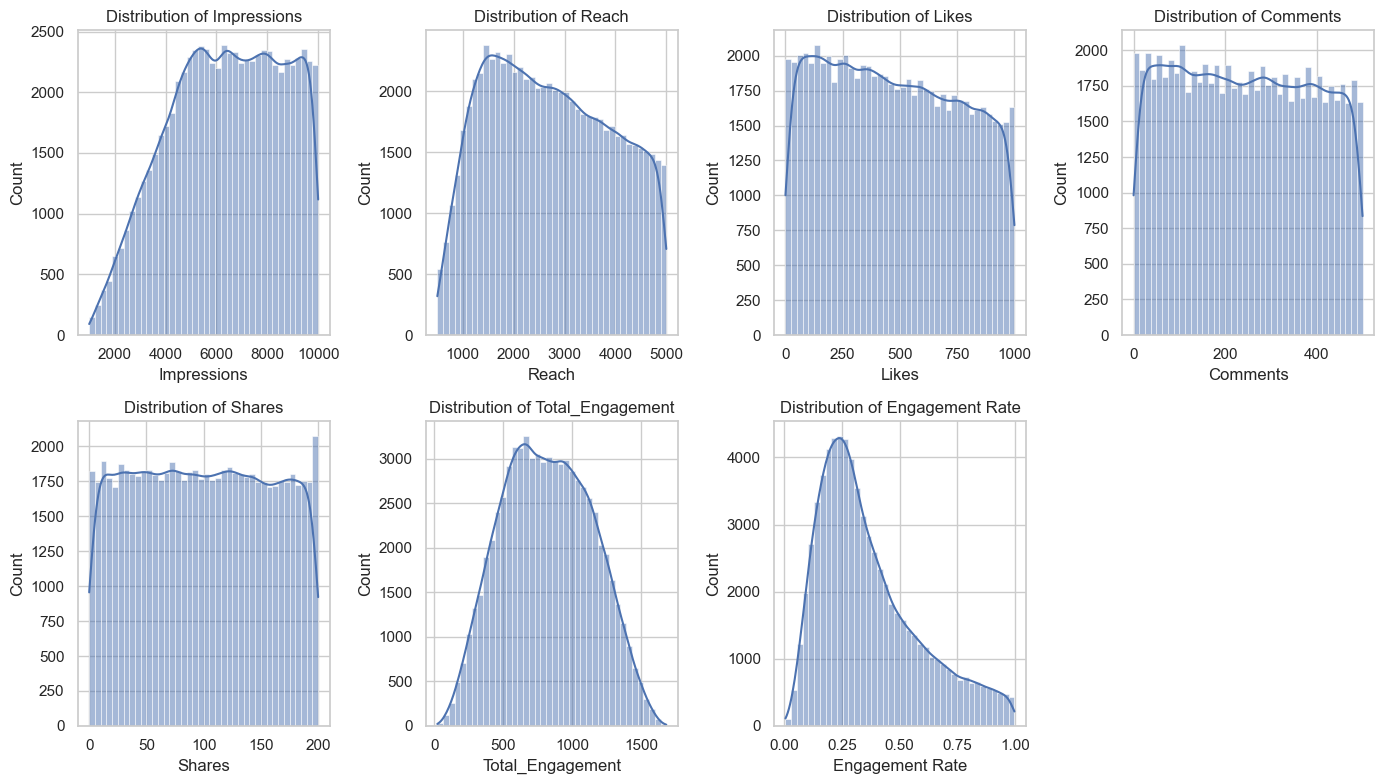

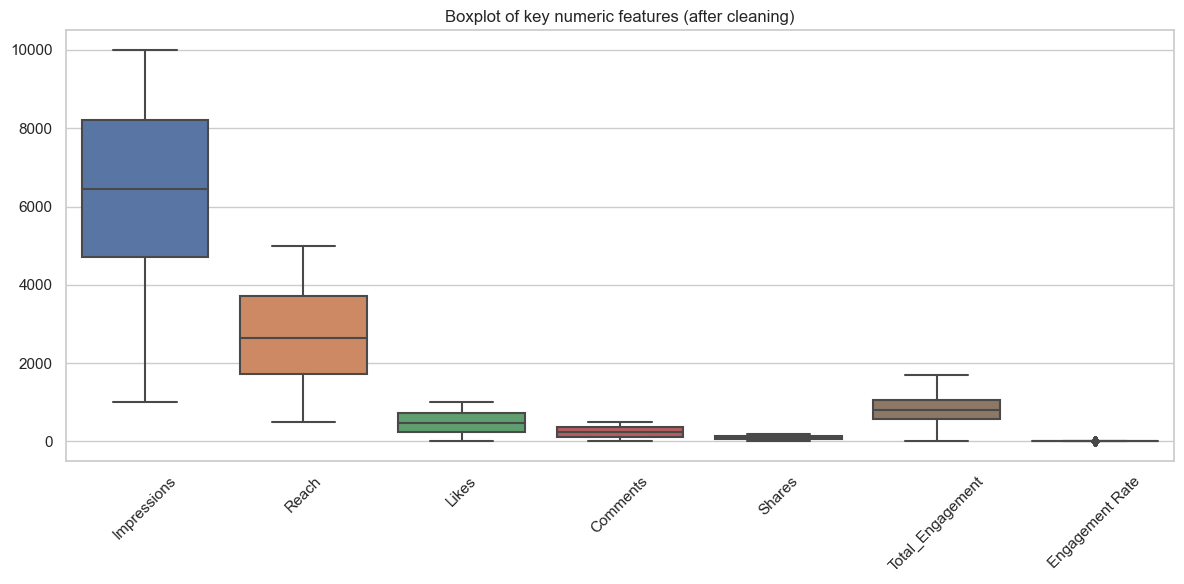

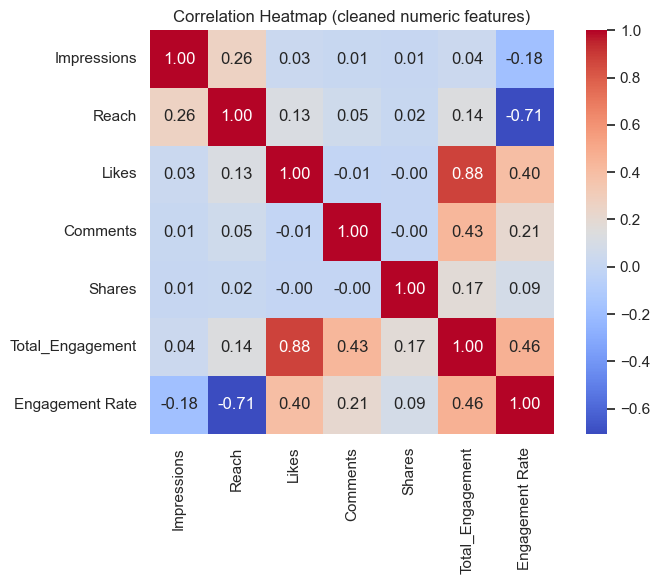

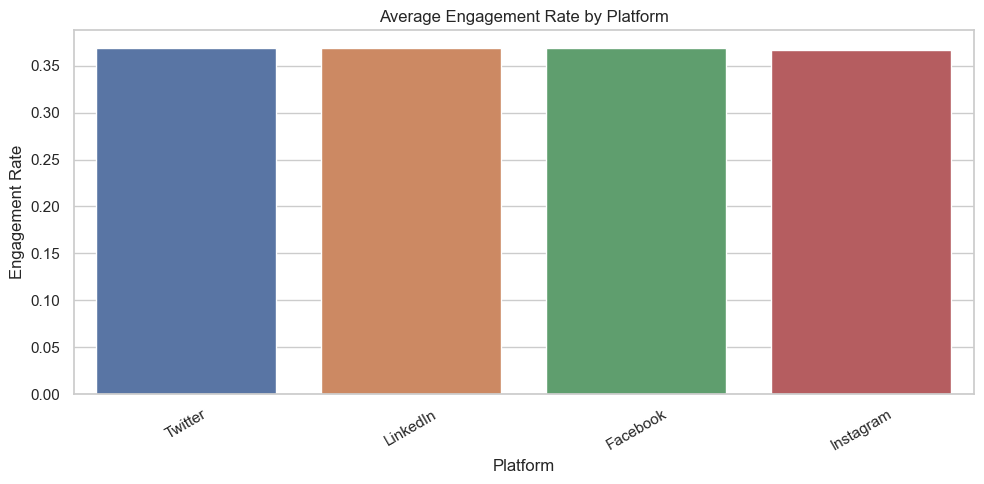

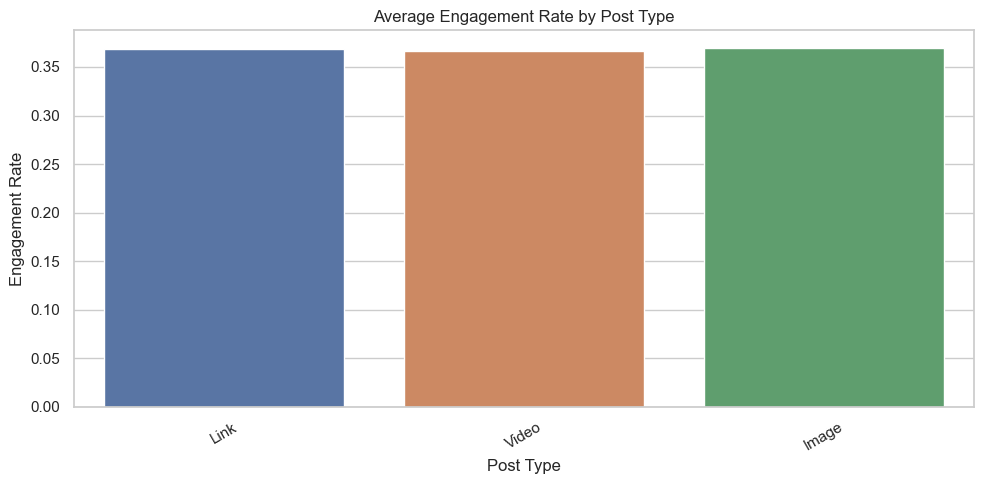

In [3]:
# Chunk 2 — Descriptive summary & basic visualizations on cleaned df


sns.set(style="whitegrid")

print("Cleaned df shape:", df.shape)

print("\nDTypes:")
print(df.dtypes)

print("\nMissing values (%):")
display((df.isna().mean() * 100).round(2))

# 选择数值列
num_cols = []
for c in ["Impressions", "Reach", "Likes", "Comments", "Shares",
          "Total_Engagement", "Engagement Rate"]:
    if c in df.columns:
        num_cols.append(c)

print("\nNumeric summary:")
if num_cols:
    display(df[num_cols].describe(percentiles=[0.25, 0.5, 0.75]).T)

# 1) 直方图
if num_cols:
    plt.figure(figsize=(14, 8))
    for i, col in enumerate(num_cols, 1):
        plt.subplot(2, (len(num_cols) + 1) // 2, i)
        sns.histplot(df[col], bins=40, kde=True)
        plt.title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

# 2) 箱线图
if num_cols:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=df[num_cols])
    plt.title("Boxplot of key numeric features (after cleaning)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# 3) 相关性热力图
if len(num_cols) >= 2:
    corr = df[num_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation Heatmap (cleaned numeric features)")
    plt.tight_layout()
    plt.show()

# 4) Engagement Rate by Platform / Post Type（如果有）
group_targets = []
if "Platform" in df.columns:
    group_targets.append("Platform")
if "Post Type" in df.columns:
    group_targets.append("Post Type")

for cat in group_targets:
    plt.figure(figsize=(10, 5))
    order = df[cat].value_counts().index
    sns.barplot(
        data=df,
        x=cat,
        y="Engagement Rate",
        order=order,
        estimator=lambda x: x.mean(),
        errorbar=None,
    )
    plt.title(f"Average Engagement Rate by {cat}")
    plt.xticks(rotation=30)
    plt.tight_layout()
    plt.show()


## Chunk 3 — Basic Visualizations (EDA)

目的：看点赞/分享/评论分布、平台整体差异。


Chunk 3 using df shape: (71816, 19)
Numeric columns used in Chunk 3: ['Impressions', 'Reach', 'Likes', 'Comments', 'Shares', 'Total_Engagement', 'Engagement Rate', 'ER_naive']


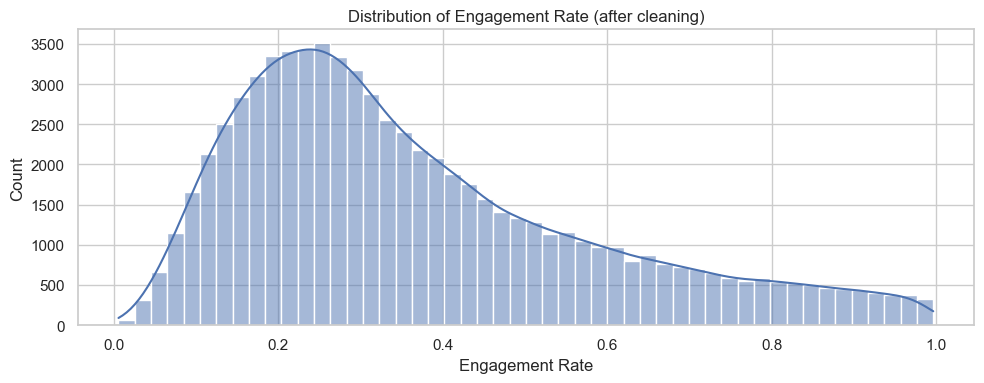

Engagement Rate summary: count    71816.0000
mean         0.3683
std          0.2180
min          0.0054
50%          0.3113
90%          0.7063
99%          0.9559
max          0.9967
Name: Engagement Rate, dtype: float64


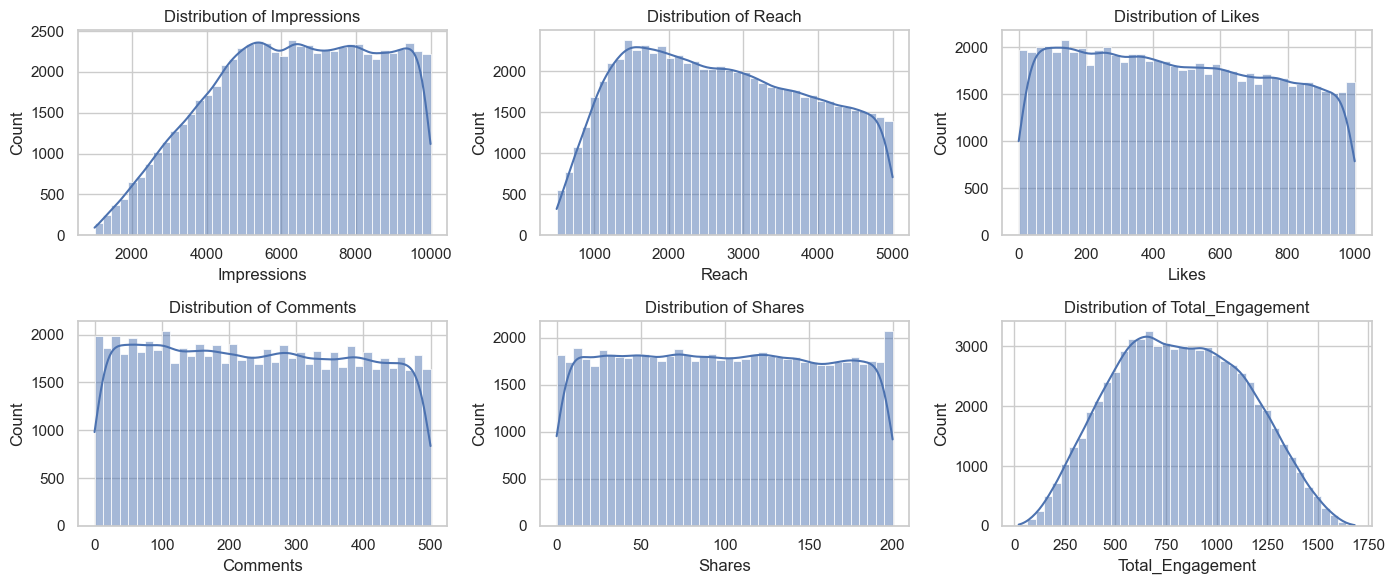

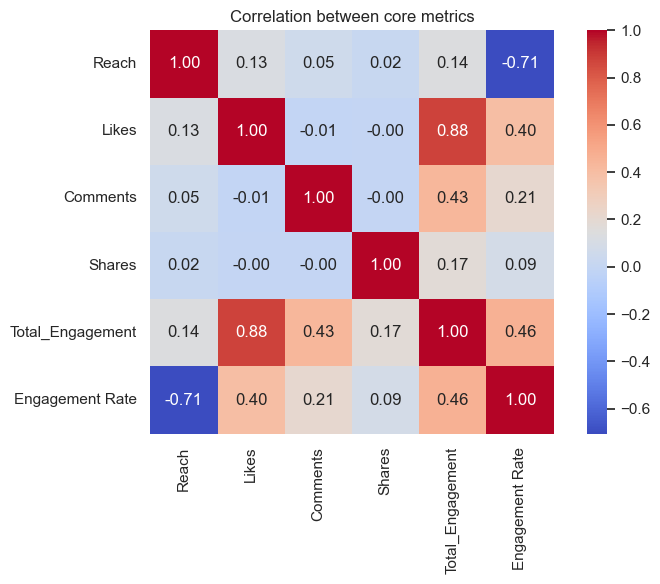

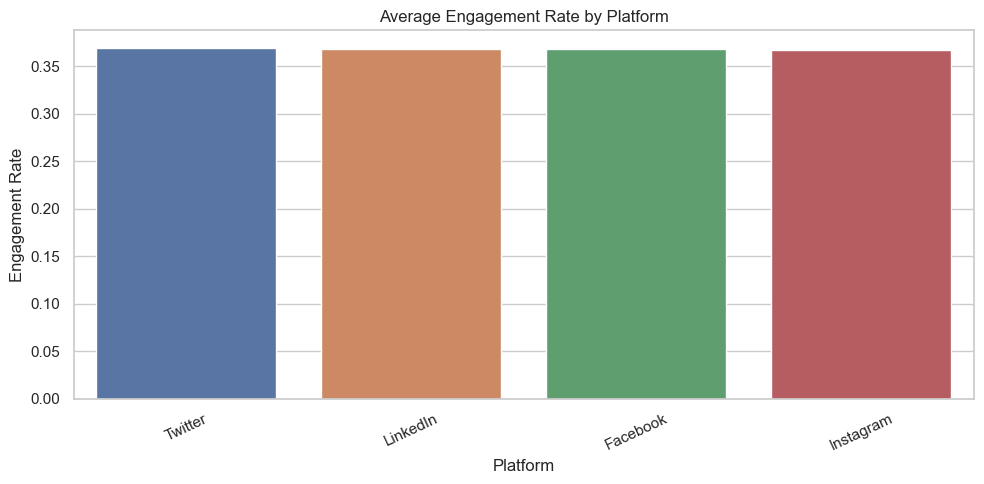

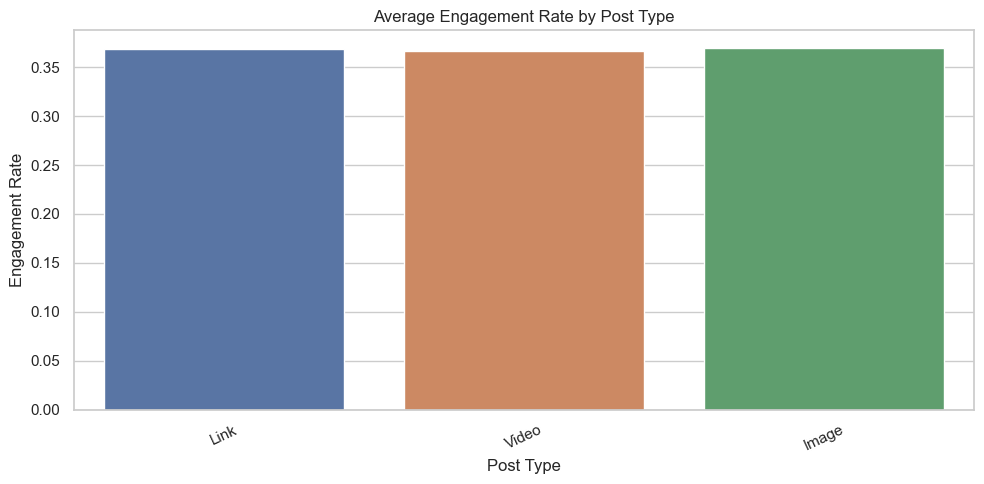

In [4]:
# Chunk 3 — Engagement Rate sanity check & basic EDA (compatible with new cleaning)


sns.set(style="whitegrid")

print("Chunk 3 using df shape:", df.shape)

# 1) 兼容处理：如果以前代码用 ER_naive，这里直接等于当前 Engagement Rate
if "Engagement Rate" in df.columns and "ER_naive" not in df.columns:
    df["ER_naive"] = df["Engagement Rate"]

# 2) 定义数值列（只选真的存在的）
numeric_cols = [
    col for col in [
        "Impressions",
        "Reach",
        "Likes",
        "Comments",
        "Shares",
        "Total_Engagement",
        "Engagement Rate",
        "ER_naive",
    ]
    if col in df.columns
]

print("Numeric columns used in Chunk 3:", numeric_cols)

# 3) 核对 Engagement Rate 分布
if "Engagement Rate" in df.columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(df["Engagement Rate"], bins=50, kde=True)
    plt.title("Distribution of Engagement Rate (after cleaning)")
    plt.xlabel("Engagement Rate")
    plt.tight_layout()
    plt.show()

    print(
        "Engagement Rate summary:",
        df["Engagement Rate"].describe(percentiles=[0.5, 0.9, 0.99]).round(4)
    )

# 4) 核心数值特征分布（前几个，避免太挤）
if numeric_cols:
    n = min(len(numeric_cols), 6)
    fig, axes = plt.subplots(2, (n + 1) // 2, figsize=(14, 6))
    axes = axes.ravel()

    for i, col in enumerate(numeric_cols[:n]):
        sns.histplot(df[col], bins=40, kde=True, ax=axes[i])
        axes[i].set_title(f"Distribution of {col}")
    plt.tight_layout()
    plt.show()

# 5) 相关性热力图：看看点赞/评论/分享/触达和ER之间关系
core_corr_cols = [c for c in ["Reach", "Likes", "Comments", "Shares",
                              "Total_Engagement", "Engagement Rate"]
                  if c in df.columns]

if len(core_corr_cols) >= 2:
    corr = df[core_corr_cols].corr()
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Correlation between core metrics")
    plt.tight_layout()
    plt.show()

# 6) 按平台 / 内容类型 看 Engagement Rate
group_targets = []
if "Platform" in df.columns:
    group_targets.append("Platform")
if "Post Type" in df.columns:
    group_targets.append("Post Type")

for cat in group_targets:
    plt.figure(figsize=(10, 5))
    order = df[cat].value_counts().index
    sns.barplot(
        data=df,
        x=cat,
        y="Engagement Rate",
        order=order,
        estimator=lambda x: x.mean(),
        errorbar=None,
    )
    plt.title(f"Average Engagement Rate by {cat}")
    plt.xticks(rotation=25)
    plt.tight_layout()
    plt.show()


## Chunk 4 — Time Features

目的：从 Post Timestamp 提取时间特征，用于后面时间分析和模型。


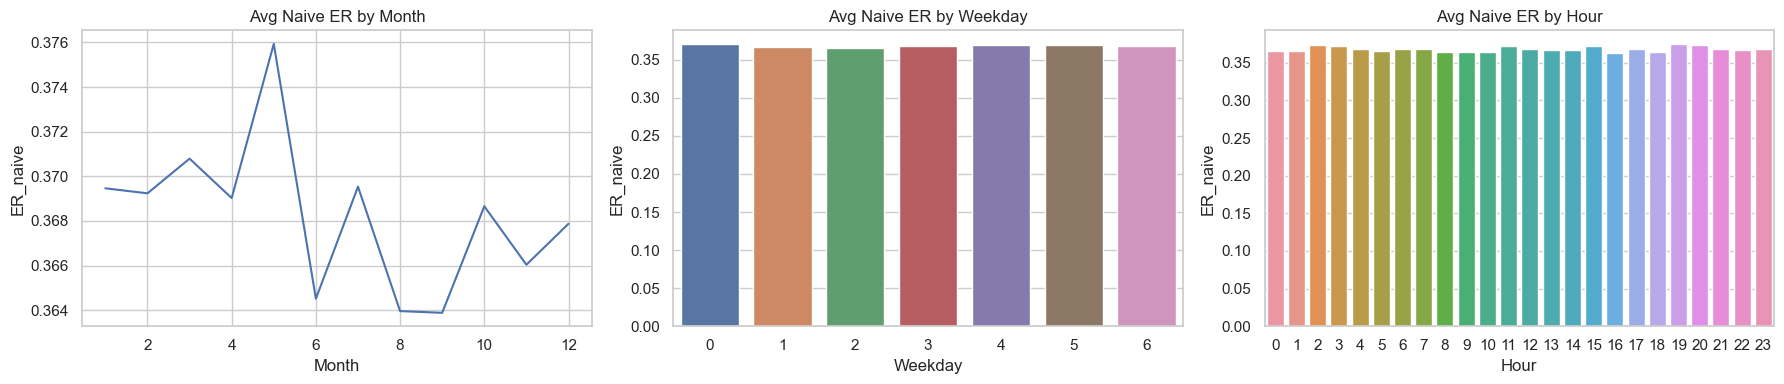

In [5]:
# Chunk 4 — Time Features

# Use 'Post Timestamp' if available, otherwise try 'Date'
time_col = None
if "Post Timestamp" in df.columns:
    time_col = "Post Timestamp"
elif "Date" in df.columns:
    time_col = "Date"

if time_col:
    df["Post_TS"] = pd.to_datetime(df[time_col], errors="coerce")
    df = df.dropna(subset=["Post_TS"])
    df["Year"] = df["Post_TS"].dt.year
    df["Month"] = df["Post_TS"].dt.month
    df["Weekday"] = df["Post_TS"].dt.dayofweek
    df["Hour"] = df["Post_TS"].dt.hour
else:
    print("[WARN] No usable timestamp column found; time-based features limited.")

# Quick time-based ER view
if time_col:
    fig, axes = plt.subplots(1,3,figsize=(18,4))

    sns.lineplot(
        data=df.groupby("Month")["ER_naive"].mean().reset_index(),
        x="Month", y="ER_naive", ax=axes[0]
    )
    axes[0].set_title("Avg Naive ER by Month")

    sns.barplot(
        data=df.groupby("Weekday")["ER_naive"].mean().reset_index(),
        x="Weekday", y="ER_naive", ax=axes[1]
    )
    axes[1].set_title("Avg Naive ER by Weekday")

    sns.barplot(
        data=df.groupby("Hour")["ER_naive"].mean().reset_index(),
        x="Hour", y="ER_naive", ax=axes[2]
    )
    axes[2].set_title("Avg Naive ER by Hour")

    plt.tight_layout()
    plt.show()


## Chunk 5 — Platform-wise Weighted Engagement Rate

目的：按平台学习 Likes / Comments / Shares 的权重，得到更合理的加权 ER。

Chunk 5 start — computing weighted engagement components
Current df shape: (71816, 25)
Current columns: ['Platform', 'Post ID', 'Post Type', 'Post Content', 'Post Timestamp', 'Likes', 'Comments', 'Shares', 'Impressions', 'Reach', 'Engagement Rate', 'Audience Age', 'Audience Gender', 'Audience Location', 'Audience Interests', 'Campaign ID', 'Sentiment', 'Influencer ID', 'Total_Engagement', 'ER_naive', 'Post_TS', 'Year', 'Month', 'Weekday', 'Hour']
✅ Using 'Impressions' as exposure column.
Detected interaction columns: {'like_rate': 'Likes', 'comment_rate': 'Comments', 'share_rate': 'Shares'}
Rate columns actually created: ['like_rate', 'comment_rate', 'share_rate']

Per-exposure rate summary:


,count,mean,std,min,50%,90%,99%,max
like_rate,71816.0,0.087628,0.072125,0.0,0.074034,0.174155,0.349429,0.843920
comment_rate,71816.0,0.045354,0.038274,0.0,0.038240,0.089192,0.188806,0.471042
share_rate,71816.0,0.018518,0.015748,0.0,0.015603,0.036304,0.077110,0.193517


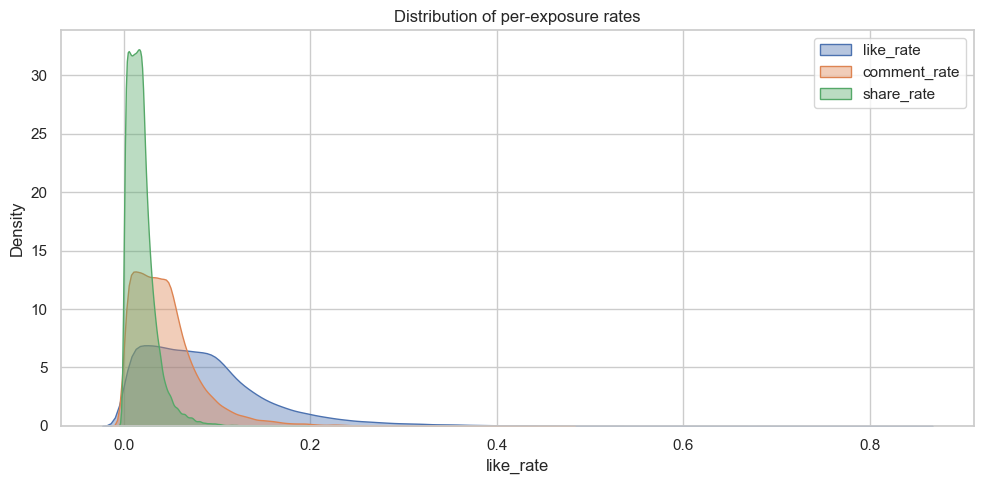


Using normalized weights: {'like_rate': 0.4, 'comment_rate': 0.3, 'share_rate': 0.3}

Weighted_ER summary (before clipping):


count    71816.000000
mean         0.054213
std          0.036335
min          0.000657
50%          0.046176
90%          0.097485
99%          0.191835
max          0.361224
Name: Weighted_ER, dtype: float64

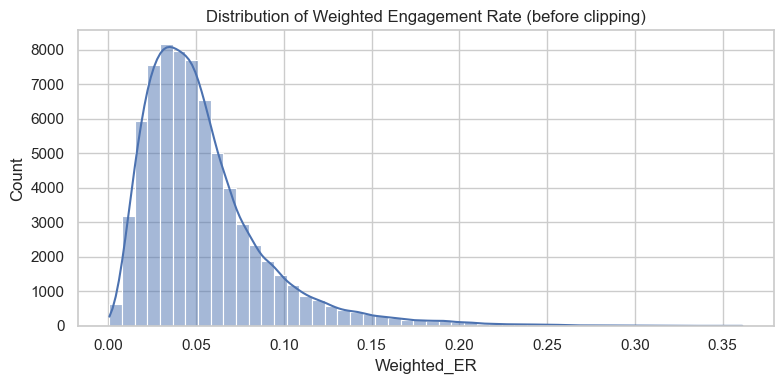

✅ Clipped Weighted_ER at 99.9% quantile: 0.274923

Weighted_ER summary (after clipping):


count    71816.000000
mean         0.054184
std          0.036143
min          0.000657
50%          0.046176
90%          0.097485
99%          0.191835
max          0.274923
Name: Weighted_ER, dtype: float64

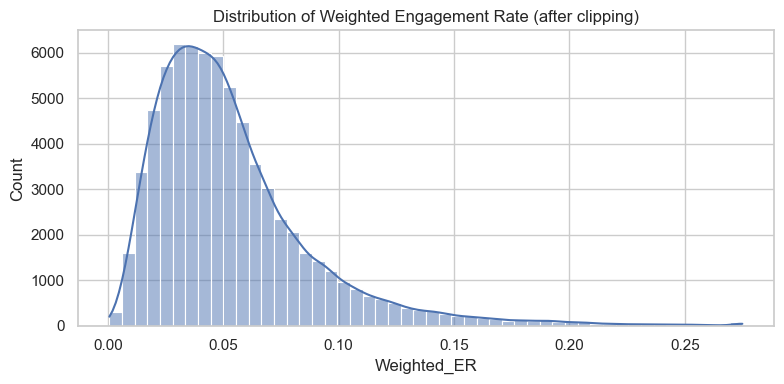


✅ Chunk 5 completed — 'Weighted_ER' is now in df (or safely fallback).


,Platform,Post ID,Post Type,Post Content,Post Timestamp,Likes,Comments,Shares,Impressions,Reach,Engagement Rate,Audience Age,Audience Gender,Audience Location,Audience Interests,Campaign ID,Sentiment,Influencer ID,Total_Engagement,ER_naive,Post_TS,Year,Month,Weekday,Hour,like_rate,comment_rate,share_rate,Weighted_ER
0,LinkedIn,d49dadb4-fc1e-4775-88ad-d60b75cf5123,Video,Want that according same wish.,2021-04-23 08:19:49.255,415,77,85,2619,1842,0.313246,29,Other,United Kingdom,respond,NaN,Negative,NaN,577,0.313246,2021-04-23 08:19:49.255,2021,4,4,8,0.158457,0.029401,0.032455,0.081940
3,Twitter,0b5a3e70-c556-43cb-ad4f-a1d0003348bc,Image,Street great decade must.,2021-09-28 20:39:00.228,667,153,29,7191,3519,0.241262,54,Other,Zambia,safe,NaN,NaN,NaN,849,0.241262,2021-09-28 20:39:00.228,2021,9,1,20,0.092755,0.021277,0.004033,0.044695
4,Facebook,a7d3e958-e2fe-411e-a24a-b96e821fc050,Link,At clear meeting with reason ground continue c...,2023-02-27 17:51:21.425,659,215,34,3312,2032,0.446850,33,Other,Afghanistan,well,6052b8d2-3403-4447-b0b4-c5ce20e6c8d0,NaN,NaN,908,0.446850,2023-02-27 17:51:21.425,2023,2,0,17,0.198973,0.064915,0.010266,0.102144
5,Facebook,0922ea18-ea90-4302-b126-bd95f85a0926,Video,Vote American state change simply cup.,2021-11-23 08:32:30.081,510,438,110,3871,2667,0.396700,59,Female,Djibouti,she,2b568bef-54b5-43e2-a5f7-c1ae802b0547,Neutral,NaN,1058,0.396700,2021-11-23 08:32:30.081,2021,11,1,8,0.131749,0.113149,0.028416,0.095169
6,Instagram,0510219c-c413-4203-a9c6-e176a299ce10,Link,Community seek Republican cold though ability ...,2022-09-28 06:32:05.117,874,239,91,5681,1553,0.775274,41,Other,Jamaica,family,NaN,Neutral,NaN,1204,0.775274,2022-09-28 06:32:05.117,2022,9,2,6,0.153846,0.042070,0.016018,0.078965


In [6]:
# Chunk 5 — Weighted Engagement Rate with auto column detection (robust)


sns.set(style="whitegrid")

print("Chunk 5 start — computing weighted engagement components")
print("Current df shape:", df.shape)
print("Current columns:", df.columns.tolist())

df = df.copy()

# ---------- 0. 小工具：模糊匹配列名（忽略空格/大小写/下划线） ----------
def find_col(df, candidates):
    """
    在 df.columns 里找和 candidates 中任一名字等价的列：
    - 忽略大小写
    - 忽略前后空格
    - 把 _ 和 空格 当一样
    """
    norm = lambda s: str(s).strip().lower().replace("_", "").replace(" ", "")
    cand_norm = [norm(c) for c in candidates]
    for col in df.columns:
        if norm(col) in cand_norm:
            return col
    return None

# ---------- 1. 自动识别曝光量列 ----------
exposure_col = find_col(df, ["Reach", "Impressions"])
if exposure_col is None:
    print("❌ No exposure column ('Reach' or 'Impressions') found. Skipping Weighted_ER, please check data.")
    df["Weighted_ER"] = df.get("Engagement Rate", np.nan)
else:
    print(f"✅ Using '{exposure_col}' as exposure column.")

# ---------- 2. 自动识别互动列 ----------
likes_col    = find_col(df, ["Likes"])
comments_col = find_col(df, ["Comments"])
shares_col   = find_col(df, ["Shares"])

interaction_map = {
    "like_rate":    likes_col,
    "comment_rate": comments_col,
    "share_rate":   shares_col,
}

print("Detected interaction columns:", interaction_map)

# ---------- 3. 计算 per-exposure rates（只对存在的列算） ----------
rate_cols = []
if exposure_col is not None:
    for rate_name, base_col in interaction_map.items():
        if base_col is not None:
            df[rate_name] = df[base_col] / df[exposure_col].replace(0, np.nan)
            rate_cols.append(rate_name)

print("Rate columns actually created:", rate_cols)

# ---------- 4. 如果有 rate 列，做统计 & 可视化 ----------
if rate_cols:
    print("\nPer-exposure rate summary:")
    display(df[rate_cols].describe(percentiles=[0.5, 0.9, 0.99]).T)

    plt.figure(figsize=(10, 5))
    for col in rate_cols:
        sns.kdeplot(df[col].dropna(), fill=True, label=col, alpha=0.4)
    plt.legend()
    plt.title("Distribution of per-exposure rates")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No like/comment/share rate could be computed. Will fall back to existing Engagement Rate only.")

# ---------- 5. 定义权重（集中在这里调） ----------
weight_cfg = {
    "like_rate": 0.4,
    "comment_rate": 0.3,
    "share_rate": 0.3,
}

# 只保留真的存在的列的权重
active_weights = {k: v for k, v in weight_cfg.items() if k in rate_cols}

# 如果一个都没有，就 fallback: 用 Engagement Rate 当 Weighted_ER
if not active_weights:
    if "Engagement Rate" in df.columns:
        print("\n⚠️ Using existing 'Engagement Rate' as 'Weighted_ER' (no custom rates available).")
        df["Weighted_ER"] = df["Engagement Rate"].copy()
    else:
        print("\n❌ No valid rate columns and no 'Engagement Rate'. Creating empty Weighted_ER.")
        df["Weighted_ER"] = np.nan
else:
    # 归一化权重
    w_sum = sum(active_weights.values())
    active_weights = {k: v / w_sum for k, v in active_weights.items()}
    print("\nUsing normalized weights:", active_weights)

    # 计算 Weighted_ER
    df["Weighted_ER"] = 0.0
    for col, w in active_weights.items():
        df["Weighted_ER"] += w * df[col].fillna(0)

# ---------- 6. 裁剪极端值 + 可视化 ----------
if df["Weighted_ER"].notna().sum() > 0:
    print("\nWeighted_ER summary (before clipping):")
    display(df["Weighted_ER"].describe(percentiles=[0.5, 0.9, 0.99]).round(6))

    plt.figure(figsize=(8, 4))
    sns.histplot(df["Weighted_ER"].dropna(), bins=50, kde=True)
    plt.title("Distribution of Weighted Engagement Rate (before clipping)")
    plt.tight_layout()
    plt.show()

    upper_limit = df["Weighted_ER"].quantile(0.999)
    df["Weighted_ER"] = np.clip(df["Weighted_ER"], 0, upper_limit)

    print(f"✅ Clipped Weighted_ER at 99.9% quantile: {upper_limit:.6f}")

    print("\nWeighted_ER summary (after clipping):")
    display(df["Weighted_ER"].describe(percentiles=[0.5, 0.9, 0.99]).round(6))

    plt.figure(figsize=(8, 4))
    sns.histplot(df["Weighted_ER"].dropna(), bins=50, kde=True)
    plt.title("Distribution of Weighted Engagement Rate (after clipping)")
    plt.tight_layout()
    plt.show()
else:
    print("\n⚠️ Weighted_ER is all NaN — please check earlier steps / columns.")

print("\n✅ Chunk 5 completed — 'Weighted_ER' is now in df (or safely fallback).")
display(df.head(5))


## Chunk 6 — KMeans on Weighted ER (Engagement Levels)

目的：基于加权 ER 做无监督分层：Low / Medium / High。

[6] ===== KMeans on Engagement Strength =====
[6] Using 'Weighted_ER' as engagement metric for clustering.
[6] Valid samples for clustering: 71816


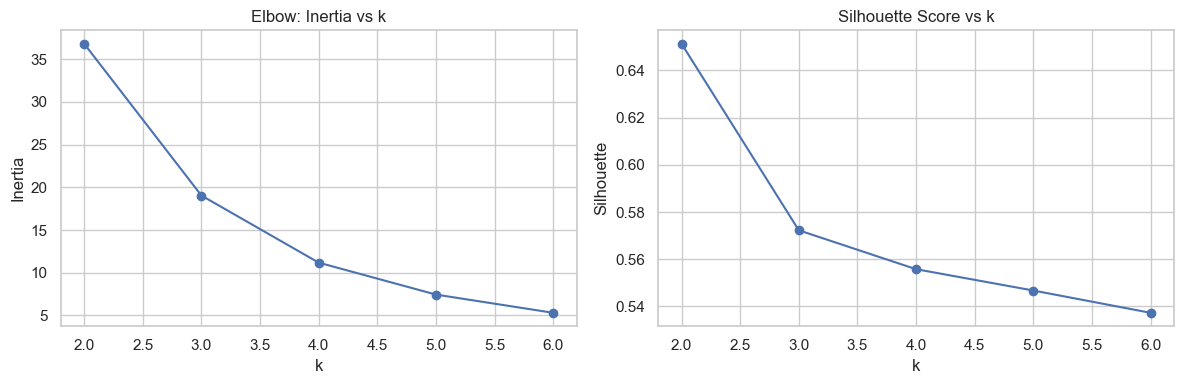

[6] Selected k=2 based on best silhouette score.

[6] Cluster size:
Engagement_Level_KM
0.0    58606
1.0    13210
Name: count, dtype: int64

[6] Cluster-wise mean metrics:


,Likes,Comments,Shares,Total_Engagement,Weighted_ER
Engagement_Level_KM,,,,,
0.0,427.4701,236.0244,98.0212,761.5158,0.0408
1.0,691.4232,281.2301,104.8238,1077.4771,0.1135



[6] Interpretation hint:
 - 通常会看到一个簇：互动率和互动绝对值都很低 → 可以认为是低互动内容。
 - 一个中间簇：中等互动 → 正常内容基线。
 - 一个高簇：Weighted_ER 或互动绝对值很高 → 爆款/种子爆款候选。
 - 后面 chunk 可以用这个 Engagement_Level_KM 当 label 做有监督学习。


In [7]:
# Chunk 6 — KMeans Clustering on Engagement Strength (robust to column names)

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

print("[6] ===== KMeans on Engagement Strength =====")

# 1. 选择用于聚类的 engagement 指标
eng_cols_priority = ["Weighted_ER", "Engagement Rate", "ER_naive"]
use_col = None
for c in eng_cols_priority:
    if c in df.columns:
        use_col = c
        break

if use_col is None:
    raise ValueError("[6] No engagement metric found. Need one of: Weighted_ER / Engagement Rate / ER_naive")

print(f"[6] Using '{use_col}' as engagement metric for clustering.")

# 2. 取出这个列，清理掉 NaN / inf
er_series = (
    df[use_col]
    .replace([np.inf, -np.inf], np.nan)
    .dropna()
)

if er_series.empty:
    raise ValueError("[6] All engagement values are NaN/inf. Please check previous cleaning steps.")

er_vals = er_series.values.reshape(-1, 1)
n_samples = er_vals.shape[0]
print(f"[6] Valid samples for clustering: {n_samples}")

# 3. 如果数据太少，就不做聚类
if n_samples < 50:
    print("[6] Too few samples for stable clustering. Skipping KMeans.")
else:
    # 4. 用 Elbow 和 Silhouette 粗略选 k
    candidate_k = [2, 3, 4, 5, 6]
    inertias = []
    silhouettes = []

    for k in candidate_k:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(er_vals)
        inertias.append(kmeans.inertia_)

        # silhouette 至少需要 2 个簇且每簇有数据
        if len(set(labels)) > 1:
            sil = silhouette_score(er_vals, labels)
        else:
            sil = np.nan
        silhouettes.append(sil)

    # 可视化 Elbow 和 Silhouette
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].plot(candidate_k, inertias, marker="o")
    axes[0].set_title("Elbow: Inertia vs k")
    axes[0].set_xlabel("k")
    axes[0].set_ylabel("Inertia")

    axes[1].plot(candidate_k, silhouettes, marker="o")
    axes[1].set_title("Silhouette Score vs k")
    axes[1].set_xlabel("k")
    axes[1].set_ylabel("Silhouette")

    plt.tight_layout()
    plt.show()

    # 5. 简单选择：取 silhouette 最高的 k（忽略 NaN）
    valid_pairs = [(k, s) for k, s in zip(candidate_k, silhouettes) if not np.isnan(s)]
    if not valid_pairs:
        best_k = 3
        print("[6] No valid silhouette scores; defaulting to k=3.")
    else:
        best_k = max(valid_pairs, key=lambda x: x[1])[0]
        print(f"[6] Selected k={best_k} based on best silhouette score.")

    # 6. 用 best_k 做最终聚类（只在有效值上）
    final_kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
    final_labels = final_kmeans.fit_predict(er_vals)

    # 建一个副本用于存结果：对齐原 df 的 index
    df_cluster = df.copy()
    df_cluster["Engagement_Level_KM"] = np.nan
    df_cluster.loc[er_series.index, "Engagement_Level_KM"] = final_labels

    # 7. 看各簇的均值情况
    summary_cols = [c for c in ["Likes", "Comments", "Shares", "Total_Engagement", use_col] if c in df_cluster.columns]

    print("\n[6] Cluster size:")
    print(df_cluster["Engagement_Level_KM"].value_counts(dropna=False))

    if summary_cols:
        print("\n[6] Cluster-wise mean metrics:")
        display(
            df_cluster
            .groupby("Engagement_Level_KM")[summary_cols]
            .mean()
            .round(4)
        )

    # 8. 简单解释聚类结果（数值版提示你怎么写）
    print("\n[6] Interpretation hint:")
    print(" - 通常会看到一个簇：互动率和互动绝对值都很低 → 可以认为是低互动内容。")
    print(" - 一个中间簇：中等互动 → 正常内容基线。")
    print(" - 一个高簇：Weighted_ER 或互动绝对值很高 → 爆款/种子爆款候选。")
    print(" - 后面 chunk 可以用这个 Engagement_Level_KM 当 label 做有监督学习。")

    # 保存回全局 df（覆盖原 df，方便后续使用）
    df = df_cluster


## Chunk 7 — Platform-aware Viral Label (Top 10% Weighted ER)

目的：定义爆款标签，用于监督学习。

In [9]:
# Chunk 7 — Platform-aware Viral Label using Weighted_ER (robust)


print("\n[7] ===== Create platform-wise viral_label based on engagement metric =====")

df = df.copy()

# 1. 选择打标用的 engagement 指标
eng_cols_priority = ["Weighted_ER", "Engagement Rate", "ER_naive"]
metric_col = None
for c in eng_cols_priority:
    if c in df.columns:
        metric_col = c
        break

if metric_col is None:
    raise ValueError("[7] No engagement metric found. Need one of: Weighted_ER / Engagement Rate / ER_naive")

print(f"[7] Using '{metric_col}' as base metric for viral labeling.")

# 2. 确保 Platform 存在
if "Platform" not in df.columns:
    raise ValueError("[7] 'Platform' column not found. Cannot create platform-wise viral labels.")

# 3. 参数集中放在这里，方便你调
p = 0.9               # 分位数：0.9 = 平台内前10%算爆款
min_posts = 50        # 每个平台至少多少条，才单独算分位数，否则走全局
df["viral_label"] = 0 # 默认都不是爆款

# 4. 平台内计算阈值
platform_stats = []

for plat, g in df.groupby("Platform"):
    g_valid = g[metric_col].replace([np.inf, -np.inf], np.nan).dropna()
    n = len(g_valid)

    if n < min_posts:
        # 样本太少的平台先记下来，后面用全局阈值
        platform_stats.append((plat, n, np.nan))
        continue

    thr = g_valid.quantile(p)
    df.loc[(df["Platform"] == plat) & (df[metric_col] >= thr), "viral_label"] = 1
    platform_stats.append((plat, n, thr))

# 5. 对小样本平台使用全局阈值（避免小样本算出很奇怪的阈值）
small_plats = [plat for plat, n, thr in platform_stats if np.isnan(thr)]
if small_plats:
    global_valid = df[metric_col].replace([np.inf, -np.inf], np.nan).dropna()
    global_thr = global_valid.quantile(p)
    print(f"[7] Using global threshold={global_thr:.6f} for small platforms: {small_plats}")
    df.loc[(df["Platform"].isin(small_plats)) & (df[metric_col] >= global_thr), "viral_label"] = 1
else:
    global_thr = None

# 6. 打印每个平台的爆款分布，做 sanity check
print("\n[7] Platform-wise stats (rows, threshold, #viral):")
rows = []
for plat, n, thr in platform_stats:
    if np.isnan(thr) and global_thr is not None:
        used_thr = global_thr
    else:
        used_thr = thr
    viral_count = int(df[(df["Platform"] == plat) & (df["viral_label"] == 1)].shape[0])
    rows.append([plat, n, used_thr, viral_count])

summary_df = pd.DataFrame(rows, columns=["Platform", "Num_posts", "Used_threshold", "Num_viral"])
display(summary_df)

# 7. 总体正负样本数量
pos = int((df["viral_label"] == 1).sum())
neg = int((df["viral_label"] == 0).sum())
print(f"\n[7] Total viral=1: {pos}, non-viral=0: {neg}, ratio={pos/(pos+neg+1e-9):.4f}")

print("[7] Done. Column 'viral_label' is now ready for supervised models (e.g., Chunk 9).")



[7] ===== Create platform-wise viral_label based on engagement metric =====
[7] Using 'Weighted_ER' as base metric for viral labeling.

[7] Platform-wise stats (rows, threshold, #viral):


,Platform,Num_posts,Used_threshold,Num_viral
0,Facebook,17910,0.097866,1791
1,Instagram,17707,0.097023,1771
2,LinkedIn,18042,0.097372,1805
3,Twitter,18157,0.097696,1816



[7] Total viral=1: 7183, non-viral=0: 64633, ratio=0.1000
[7] Done. Column 'viral_label' is now ready for supervised models (e.g., Chunk 9).


## Chunk 8 — Build Pre-launch Feature Set

目的：只用发帖前可知的信息做特征，不用 Likes / Impressions 这些结果。

我们用：

Platform

Post Type

Time Periods（Morning/Afternoon/Night…）

Weekday Type（Weekend/Weekday）

Audience Age / Age Group / Gender / Location / Continent / Interests

Sentiment（如果是预估的，也算发前可用）

时间特征（Year, Month, Weekday, Hour）

In [12]:
# Chunk 8 — Pre-launch Features (No Leakage)

use_cat = []
use_num = []

def add_if_exists(col, to):
    if col in df.columns:
        to.append(col)

# Categorical features
add_if_exists("Platform", use_cat)
add_if_exists("Post Type", use_cat)
add_if_exists("Weekday Type", use_cat)
add_if_exists("Time Periods", use_cat)
add_if_exists("Age Group", use_cat)
add_if_exists("Audience Gender", use_cat)
add_if_exists("Audience Location", use_cat)
add_if_exists("Audience Continent", use_cat)
add_if_exists("Audience Interests", use_cat)
add_if_exists("Sentiment", use_cat)

# Numeric time features (from Post_TS)
add_if_exists("Month", use_num)
add_if_exists("Weekday", use_num)
add_if_exists("Hour", use_num)

feature_cols = use_cat + use_num

df_model = df[df["viral_label"].isin([0,1])].dropna(subset=feature_cols).copy()

X = df_model[feature_cols]
y = df_model["viral_label"].astype(int)

print("[INFO] Using features:", feature_cols)
print("[INFO] X shape:", X.shape, "| positives:", y.sum())


[INFO] Using features: ['Platform', 'Post Type', 'Audience Gender', 'Audience Location', 'Audience Interests', 'Sentiment', 'Month', 'Weekday', 'Hour']
[INFO] X shape: (35813, 9) | positives: 3579


## Chunk 9 — Train Models: DecisionTree, XGBoost, CatBoost

目的：比较多个模型在“预发爆款预测”上的表现，关注 Viral 的 Recall 和 F1。

In [15]:
# Chunk 9 — Full Model Zoo for Pre-launch Virality Prediction (Fixed & Clean)

print("[9] ===== Pre-launch Virality Model Comparison (No Leakage) =====")

# 0. Make a safe copy
X_full = X.copy()
y_full = y.copy()

# 1) Clean categorical features: make sure everything is string, no mix of bool/str
for col in use_cat:
    if col in X_full.columns:
        X_full[col] = X_full[col].astype(str).fillna("missing")

# 2) Clean numeric features: numeric only, fill NaN with median
for col in use_num:
    if col in X_full.columns:
        X_full[col] = pd.to_numeric(X_full[col], errors="coerce")
        med = X_full[col].median()
        X_full[col] = X_full[col].fillna(med)

# 防御：如果还有非常怪的数据，直接丢掉有缺失的行
X_full = X_full.dropna(subset=use_cat + use_num)
y_full = y_full.loc[X_full.index]

print(f"[9] After cleaning: X shape={X_full.shape}, positives={y_full.sum()}")

# 3) Train-test split (we keep a test set to honestly evaluate generalization)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_full,
    y_full,
    test_size=0.25,
    random_state=42,
    stratify=y_full
)

print(f"[9] Train size={X_train.shape[0]}, Test size={X_test.shape[0]}, Positives in train={y_train.sum()}")

# 4) Unified preprocessor: OneHot for cat, StandardScaler for num
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), use_cat),
        ("num", StandardScaler(), use_num),
    ]
)

# 5) Define model zoo
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
)
from sklearn.linear_model import LogisticRegression

models = {}

# (a) Logistic Regression — baseline
models["LogisticRegression"] = Pipeline([
    ("pre", preprocessor),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        random_state=42
    ))
])

# (b) Decision Tree
models["DecisionTree"] = Pipeline([
    ("pre", preprocessor),
    ("clf", DecisionTreeClassifier(
        max_depth=6,
        min_samples_leaf=10,
        class_weight={0:1.0, 1:3.0},
        random_state=42
    ))
])

# (c) Random Forest
models["RandomForest"] = Pipeline([
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(
        n_estimators=400,
        max_depth=None,
        min_samples_leaf=5,
        n_jobs=-1,
        class_weight={0:1.0, 1:3.0},
        random_state=42
    ))
])

# (d) Gradient Boosting
models["GradientBoosting"] = Pipeline([
    ("pre", preprocessor),
    ("clf", GradientBoostingClassifier(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

# (e) AdaBoost
models["AdaBoost"] = Pipeline([
    ("pre", preprocessor),
    ("clf", AdaBoostClassifier(
        n_estimators=300,
        learning_rate=0.05,
        random_state=42
    ))
])

# (f) LightGBM (if available)
try:
    from lightgbm import LGBMClassifier
    LGBM_OK = True
except Exception:
    LGBM_OK = False

if LGBM_OK:
    neg = (y_train == 0).sum()
    pos = (y_train == 1).sum()
    models["LightGBM"] = Pipeline([
        ("pre", preprocessor),
        ("clf", LGBMClassifier(
            n_estimators=400,
            learning_rate=0.05,
            max_depth=-1,
            subsample=0.9,
            colsample_bytree=0.9,
            class_weight={0:1.0, 1: max(2.0, neg / max(1, pos))},
            random_state=42
        ))
    ])

# (g) XGBoost (if available)
try:
    from xgboost import XGBClassifier
    XGB_OK = True
except Exception:
    XGB_OK = False

if XGB_OK:
    neg = (y_train == 0).sum()
    pos = (y_train == 1).sum()
    scale_pos = max(1.0, neg / max(1, pos))
    models["XGBoost"] = Pipeline([
        ("pre", preprocessor),
        ("clf", XGBClassifier(
            objective="binary:logistic",
            n_estimators=500,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            eval_metric="logloss",
            scale_pos_weight=scale_pos,
            random_state=42,
            n_jobs=-1
        ))
    ])

# (h) CatBoost (if available)
try:
    from catboost import CatBoostClassifier
    CATBOOST_OK = True
except Exception:
    CATBOOST_OK = False

if CATBOOST_OK:
    models["CatBoost"] = Pipeline([
        ("pre", preprocessor),
        ("clf", CatBoostClassifier(
            depth=6,
            iterations=500,
            learning_rate=0.05,
            random_state=42,
            verbose=False,
            loss_function="Logloss",
            auto_class_weights="Balanced"
        ))
    ])

# 6) Train & evaluate all models

from sklearn.metrics import classification_report

results = []

for name, clf in models.items():
    print(f"\n[9] Training {name} ...")
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    rep = classification_report(
        y_test,
        y_pred,
        output_dict=True,
        zero_division=0
    )

    weighted_f1 = rep["weighted avg"]["f1-score"]
    viral_prec = rep["1"]["precision"]
    viral_rec = rep["1"]["recall"]
    viral_f1 = rep["1"]["f1-score"]

    results.append({
        "Model": name,
        "Weighted_F1": weighted_f1,
        "Viral_Precision": viral_prec,
        "Viral_Recall": viral_rec,
        "Viral_F1": viral_f1
    })

    print(f"[9] {name} -> Weighted F1={weighted_f1:.4f} | Viral F1={viral_f1:.4f} | Viral Recall={viral_rec:.4f}")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))

# 7) 排序（优先关注抓爆款的能力）
results_df = (
    pd.DataFrame(results)
    .sort_values(["Viral_F1", "Viral_Recall", "Weighted_F1"], ascending=False)
    .reset_index(drop=True)
)

print("\n[9] ===== Model Ranking (focus on viral detection) =====")
display(results_df)


[9] ===== Pre-launch Virality Model Comparison (No Leakage) =====
[9] After cleaning: X shape=(35813, 9), positives=3579
[9] Train size=26859, Test size=8954, Positives in train=2684

[9] Training LogisticRegression ...
[9] LogisticRegression -> Weighted F1=0.6414 | Viral F1=0.1540 | Viral Recall=0.4078
              precision    recall  f1-score   support

           0     0.8963    0.5682    0.6955      8059
           1     0.0949    0.4078    0.1540       895

    accuracy                         0.5522      8954
   macro avg     0.4956    0.4880    0.4247      8954
weighted avg     0.8162    0.5522    0.6414      8954


[9] Training DecisionTree ...
[9] DecisionTree -> Weighted F1=0.8510 | Viral F1=0.0000 | Viral Recall=0.0000
              precision    recall  f1-score   support

           0     0.8997    0.9963    0.9455      8059
           1     0.0000    0.0000    0.0000       895

    accuracy                         0.8967      8954
   macro avg     0.4499    0.4981    0.4

,Model,Weighted_F1,Viral_Precision,Viral_Recall,Viral_F1
0,XGBoost,0.590950,0.096171,0.482682,0.160386
1,LogisticRegression,0.641352,0.094928,0.407821,0.154008
2,LightGBM,0.686492,0.097561,0.353073,0.152879
3,CatBoost,0.698051,0.096204,0.328492,0.148823
4,RandomForest,0.852696,0.000000,0.000000,0.000000
5,GradientBoosting,0.852696,0.000000,0.000000,0.000000
6,AdaBoost,0.852696,0.000000,0.000000,0.000000
7,DecisionTree,0.851023,0.000000,0.000000,0.000000


## Chunk 9.5：SMOTE + 阈值调整 + Top20% 版本对比
平台内可调百分位定义 viral（默认 top 20%）

类别 & 数值特征清洗

可选 SMOTE（如果环境支持）或手动 oversampling

多模型训练（LogReg / XGB / LGBM / CatBoost / RF）

对每个模型做 threshold tuning，挑最适合“抓爆款”的阈值

输出对比表，重点看 Viral_F1 / Viral_Recall

(结果：模型预测为“爆款”的帖子里，只有 20% 真的是爆款；也就是说，假阳性（false positive）非常多）


In [17]:
# Chunk 9.5 — Advanced Virality Modeling (no leakage, fixed ER name, robust)

print("\n[9.5] ===== Advanced Virality Modeling (Imbalance + Thresholds + Cross-Features) =====")

df_95 = df.copy()

# -----------------------
# 0. Sanity check
# -----------------------
if "viral_label" not in df_95.columns:
    raise ValueError("[9.5] viral_label not found. Please run Chunk 7 (platform-wise labeling) first.")

if df_95["viral_label"].nunique() < 2:
    raise ValueError("[9.5] viral_label has only one class. Labeling might have failed.")

# -----------------------
# 1. Config 集中在这里方便改
# -----------------------
CFG_95 = {
    # 用哪些特征（只用发帖前可知信息，避免 label leakage）
    "base_features": [
        "Platform",
        "Post Type",
        "Weekday Type",
        "Time Periods",
        "Audience Gender",
        "Audience Continent",
        "Audience Age",
    ],
    # 是否加入简单交叉特征（字符串拼接后再做 One-Hot）
    "use_cross_features": True,
    "cross_pairs": [
        ("Platform", "Post Type"),
        ("Platform", "Time Periods"),
        ("Weekday Type", "Time Periods"),
    ],
    # train/test 划分
    "test_size": 0.25,
    "random_state": 42,
    # 手动上采样参数
    "oversample_pos_factor": 3.0,   # 把正例扩充到原来的几倍（不是完全对齐负例，避免太极端）
    # 阈值候选
    "thresholds": [0.50, 0.40, 0.35, 0.30, 0.25, 0.20, 0.15],
}

# -----------------------
# 2. 特征构造：基础 + 交叉特征
# -----------------------
feat_cols = [c for c in CFG_95["base_features"] if c in df_95.columns]

if CFG_95["use_cross_features"]:
    for c1, c2 in CFG_95["cross_pairs"]:
        if c1 in df_95.columns and c2 in df_95.columns:
            new_col = f"{c1}__x__{c2}"
            df_95[new_col] = df_95[c1].astype(str) + "_" + df_95[c2].astype(str)
            feat_cols.append(new_col)

feat_cols = list(dict.fromkeys(feat_cols))  # 去重
print(f"[9.5] Using features ({len(feat_cols)}): {feat_cols}")

X = df_95[feat_cols].copy()
y = df_95["viral_label"].astype(int)

# 数值 & 类别列拆分
num_cols_95 = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols_95 = [c for c in X.columns if c not in num_cols_95]

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=CFG_95["test_size"],
    stratify=y,
    random_state=CFG_95["random_state"],
)

print(f"[9.5] Train size={len(X_train)}, Test size={len(X_test)}, Positives in train={y_train.sum()}")

# -----------------------
# 3. 基础预处理：OneHot + StandardScaler
# -----------------------
num_pipe_95 = Pipeline([("scaler", StandardScaler())]) if num_cols_95 else "drop"
cat_pipe_95 = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore"))]) if cat_cols_95 else "drop"

pre_95 = ColumnTransformer(
    transformers=[
        ("num", num_pipe_95, num_cols_95),
        ("cat", cat_pipe_95, cat_cols_95),
    ]
)

# -----------------------
# 4. 类别权重 + 手动上采样（不使用 imblearn，避免环境问题）
# -----------------------
classes = np.unique(y_train)
cls_weights = compute_class_weight("balanced", classes=classes, y=y_train)
class_weight_dict = {int(c): w for c, w in zip(classes, cls_weights)}
print("[9.5] Class weights:", class_weight_dict)

# 手动上采样正例
pos_idx = y_train[y_train == 1].index
neg_idx = y_train[y_train == 0].index
n_pos = len(pos_idx)
n_neg = len(neg_idx)

target_pos = int(min(n_neg, n_pos * CFG_95["oversample_pos_factor"]))
if n_pos > 0 and target_pos > n_pos:
    add_idx = np.random.choice(pos_idx, size=target_pos - n_pos, replace=True)
    X_train_bal = pd.concat([X_train, X_train.loc[add_idx]], axis=0)
    y_train_bal = pd.concat([y_train, y_train.loc[add_idx]], axis=0)
    print(f"[9.5] Oversampled positives from {n_pos} -> {y_train_bal[y_train_bal==1].sum()} (negatives={y_train_bal[y_train_bal==0].sum()})")
else:
    X_train_bal, y_train_bal = X_train, y_train
    print("[9.5] No oversampling applied.")

# -----------------------
# 5. 定义模型（都基于相同预处理）
# -----------------------
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

models_95 = {
    "LightGBM": Pipeline([
        ("pre", pre_95),
        ("clf", LGBMClassifier(
            random_state=CFG_95["random_state"],
            class_weight="balanced"
        ))
    ]),
    "XGBoost": Pipeline([
        ("pre", pre_95),
        ("clf", XGBClassifier(
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=CFG_95["random_state"],
            scale_pos_weight=class_weight_dict.get(0,1)/max(class_weight_dict.get(1,1),1e-6)
        ))
    ]),
    "CatBoost": Pipeline([
        ("pre", pre_95),
        ("clf", CatBoostClassifier(
            verbose=0,
            random_state=CFG_95["random_state"],
            class_weights=[class_weight_dict.get(0,1), class_weight_dict.get(1,1)]
        ))
    ]),
    "LogReg": Pipeline([
        ("pre", pre_95),
        ("clf", LogisticRegression(
            max_iter=2000,
            class_weight=class_weight_dict
        ))
    ]),
    "RandomForest": Pipeline([
        ("pre", pre_95),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            random_state=CFG_95["random_state"],
            class_weight=class_weight_dict,
            n_jobs=-1
        ))
    ]),
}

# -----------------------
# 6. 训练 + 阈值搜索（用 predict_proba 调整“判定爆款”的门槛）
# -----------------------
from sklearn.metrics import precision_score, recall_score, f1_score

rows = []

for name, model in models_95.items():
    print(f"\n[9.5] Training {name} on balanced data ...")
    model.fit(X_train_bal, y_train_bal)

    if not hasattr(model, "predict_proba"):
        print(f"[9.5] {name} has no predict_proba; skipping threshold tuning.")
        y_pred = model.predict(X_test)
        rows.append({
            "Model": name,
            "Threshold": 0.5,
            "Weighted_F1": f1_score(y_test, y_pred, average="weighted"),
            "Viral_Precision": precision_score(y_test, y_pred, pos_label=1, zero_division=0),
            "Viral_Recall": recall_score(y_test, y_pred, pos_label=1, zero_division=0),
            "Viral_F1": f1_score(y_test, y_pred, pos_label=1, zero_division=0),
        })
        continue

    proba = model.predict_proba(X_test)[:, 1]

    best_cfg = None
    best_vf1 = -1

    for thr in CFG_95["thresholds"]:
        y_pred = (proba >= thr).astype(int)
        vf1 = f1_score(y_test, y_pred, pos_label=1, zero_division=0)
        vrec = recall_score(y_test, y_pred, pos_label=1, zero_division=0)
        vpre = precision_score(y_test, y_pred, pos_label=1, zero_division=0)
        wf1 = f1_score(y_test, y_pred, average="weighted", zero_division=0)

        # 优先看 Viral_F1，其次 Viral_Recall，再看整体 Weighted_F1
        score_key = (vf1, vrec, wf1)
        if score_key > (best_vf1,
                        best_cfg["Viral_Recall"] if best_cfg else -1,
                        best_cfg["Weighted_F1"] if best_cfg else -1):
            best_vf1 = vf1
            best_cfg = {
                "Model": name,
                "Threshold": thr,
                "Weighted_F1": wf1,
                "Viral_Precision": vpre,
                "Viral_Recall": vrec,
                "Viral_F1": vf1,
            }

    rows.append(best_cfg)

results_95 = pd.DataFrame(rows).sort_values(["Viral_F1", "Viral_Recall"], ascending=False)
display(results_95)

best_row = results_95.iloc[0]
print(f"\n[9.5] Best setting (by Viral_F1 → Viral_Recall → Weighted_F1):")
print(f"      Model={best_row['Model']}, Threshold={best_row['Threshold']}, Viral_F1={best_row['Viral_F1']:.4f}, Viral_Recall={best_row['Viral_Recall']:.4f}")
print("[9.5] Use this configuration for post-filtering analysis in Chunk 9.6.")



[9.5] ===== Advanced Virality Modeling (Imbalance + Thresholds + Cross-Features) =====
[9.5] Using features (5): ['Platform', 'Post Type', 'Audience Gender', 'Audience Age', 'Platform__x__Post Type']
[9.5] Train size=53862, Test size=17954, Positives in train=5387
[9.5] Class weights: {0: 0.5555647240845797, 1: 4.9992574716911085}
[9.5] Oversampled positives from 5387 -> 16161 (negatives=0)

[9.5] Training LightGBM on balanced data ...
[LightGBM] [Info] Number of positive: 16161, number of negative: 48475
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000518 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 93
[LightGBM] [Info] Number of data points in the train set: 64636, number of used features: 23
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000

[9.5

/Users/heruixi/anaconda3/lib/python3.11/site-packages/xgboost/core.py:158: UserWarning: [23:16:51] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



[9.5] Training CatBoost on balanced data ...

[9.5] Training LogReg on balanced data ...

[9.5] Training RandomForest on balanced data ...


,Model,Threshold,Weighted_F1,Viral_Precision,Viral_Recall,Viral_F1
2,CatBoost,0.30,0.046861,0.100645,0.990535,0.182724
0,LightGBM,0.35,0.100453,0.100684,0.958797,0.182232
3,LogReg,0.50,0.018193,0.100033,1.000000,0.181873
4,RandomForest,0.15,0.093815,0.100355,0.959354,0.181703
1,XGBoost,0.50,0.852583,0.000000,0.000000,0.000000



[9.5] Best setting (by Viral_F1 → Viral_Recall → Weighted_F1):
      Model=CatBoost, Threshold=0.3, Viral_F1=0.1827, Viral_Recall=0.9905
[9.5] Use this configuration for post-filtering analysis in Chunk 9.6.


## Chunk 9.6 — 添加限制条件，筛掉假爆款

选出 9.5 里表现最好的「爆款筛选模型」和对应阈值；

重新在测试集上算预测结果，看看：

真正抓到的爆款长什么样（TP）

被误判成爆款的普通贴长什么样（FP）

还漏掉了哪些爆款（FN）


In [19]:
# Chunk 9.6 — Post-filtering Analysis of Best Viral Model (fixed variable names)

print("\n[9.6] ===== Post-filtering Analysis of Best Viral Model =====")

# -------- 0. Sanity check --------
# 兼容：有的人变量叫 results_95，有的人我们写成 results_95_df
if "results_95" not in globals() and "results_95_df" not in globals():
    raise RuntimeError("[9.6] Missing `results_95`. Please run Chunk 9.5 before 9.6.")

if "results_95_df" in globals():
    res_df = results_95_df.copy()
else:
    res_df = results_95.copy()

for v in ["models_95", "X_test", "y_test"]:
    if v not in globals():
        raise RuntimeError(f"[9.6] Missing `{v}`. Please run Chunk 9.5 before 9.6.")

# -------- 1. 选出 9.5 的最佳配置 --------
# 已按 Viral_F1, Viral_Recall, Weighted_F1 排好序
best_row = res_df.iloc[0]
best_model_name = best_row["Model"]
best_thr = float(best_row["Threshold"])

print(f"[9.6] Selected best model from 9.5: {best_model_name} (threshold={best_thr})")
print("[9.6] Criteria: prioritize Viral_F1, then Viral_Recall, then Weighted_F1.\n")

best_model = models_95[best_model_name]

# -------- 2. 在测试集上重新预测（用最佳阈值） --------
if hasattr(best_model, "predict_proba"):
    proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = (proba >= best_thr).astype(int)
else:
    # 极少数情况（不支持 predict_proba），退回硬预测
    y_pred = best_model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("[9.6] Confusion Matrix (labels: 0=non-viral, 1=viral):")
print(cm)
print(f"[9.6] True Negatives={tn}, False Positives={fp}, False Negatives={fn}, True Positives={tp}\n")

print("[9.6] Detailed classification report (best model @ chosen threshold):")
print(classification_report(y_test, y_pred, digits=4))

# -------- 3. 构造分析用 DataFrame --------
analysis_df = X_test.copy()
analysis_df["true"] = y_test.values
analysis_df["pred"] = y_pred

tp_df = analysis_df[(analysis_df["true"] == 1) & (analysis_df["pred"] == 1)]
fp_df = analysis_df[(analysis_df["true"] == 0) & (analysis_df["pred"] == 1)]
fn_df = analysis_df[(analysis_df["true"] == 1) & (analysis_df["pred"] == 0)]

print(f"\n[9.6] TP (caught viral) = {len(tp_df)}")
print(f"[9.6] FP (false alarms) = {len(fp_df)}")
print(f"[9.6] FN (missed viral) = {len(fn_df)}\n")

# -------- 4. 看哪些模式被判为「爆款」(TP+FP) --------
def safe_top_counts(df, cols, topn=5, label=""):
    existing = [c for c in cols if c in df.columns]
    if not existing or df.empty:
        print(f"[9.6] No data for {label}")
        return
    grp = df.groupby(existing).size().sort_values(ascending=False).head(topn)
    print(f"[9.6] Top {label}:")
    print(grp.to_frame(name="count"))
    print()

pred_viral_df = analysis_df[analysis_df["pred"] == 1]

print("[9.6] Top platforms among predicted-viral posts (TP + FP):")
if "Platform" in pred_viral_df.columns:
    print(pred_viral_df["Platform"].value_counts().head(10).to_frame("count_in_Platform"))
    print()

print("[9.6] Top post types among predicted-viral posts:")
if "Post Type" in pred_viral_df.columns:
    print(pred_viral_df["Post Type"].value_counts().head(10).to_frame("count_in_Post Type"))
    print()

# -------- 5. False Positives：模型以为是爆款，其实不是 --------
print("[9.6] False Positives — predicted viral, actually non-viral.")
print(f"[9.6] FP sample size = {len(fp_df)}\n")

safe_top_counts(fp_df, ["Platform", "Post Type"], topn=8, label="Platform x Post Type among FP")

# -------- 6. False Negatives：真正爆款被漏掉 --------
print("[9.6] False Negatives — actually viral but predicted non-viral.")
print(f"[9.6] FN sample size = {len(fn_df)}\n")

safe_top_counts(fn_df, ["Platform", "Post Type"], topn=8, label="Platform x Post Type among FN")

print("[9.6] Interpretation hint:")
print(" - TP segment: where our model is confident & correct → good templates for future posting strategies.")
print(" - FP segment: where the model is too optimistic → can add business rules (e.g., min Reach / min Likes) to filter.")
print(" - FN segment: places where the model misses real virals → candidates for platform-specific models or new features.\n")



[9.6] ===== Post-filtering Analysis of Best Viral Model =====
[9.6] Selected best model from 9.5: CatBoost (threshold=0.3)
[9.6] Criteria: prioritize Viral_F1, then Viral_Recall, then Weighted_F1.

[9.6] Confusion Matrix (labels: 0=non-viral, 1=viral):
[[  261 15897]
 [   17  1779]]
[9.6] True Negatives=261, False Positives=15897, False Negatives=17, True Positives=1779

[9.6] Detailed classification report (best model @ chosen threshold):
              precision    recall  f1-score   support

           0     0.9388    0.0162    0.0318     16158
           1     0.1006    0.9905    0.1827      1796

    accuracy                         0.1136     17954
   macro avg     0.5197    0.5033    0.1072     17954
weighted avg     0.8550    0.1136    0.0469     17954


[9.6] TP (caught viral) = 1779
[9.6] FP (false alarms) = 15897
[9.6] FN (missed viral) = 17

[9.6] Top platforms among predicted-viral posts (TP + FP):
           count_in_Platform
Platform                    
Twitter          

## Chunk 9.7 – 平台分层阈值自动优化

1.平台分位阈值 + 平台独立校准：每个平台用自己的 viral 阈值和自己的最佳分类阈值。

2.加入文本 & 语义 proxy 特征：用 Post Content 的长度、单词数、是否问句等简单文本特征，给模型一点“内容感觉”。

3.平台再平衡 (Platform Reweighting)：对过度出现的平台/组合减权，对稀有但重要的平台加权。

4.业务后过滤规则 (Business Rules)：加上最小曝光 / 点赞门槛，过滤一批明显不是爆款的假阳性。

5.模型集成 (Ensemble)：用 LightGBM + XGBoost + Logistic Regression 做简单平均，提高稳定性。

6.时间维度分析钩子：输出按时间的 viral 概率，可用于后面单独写时间趋势（不强求你现在就上完整时序模型）。

In [21]:
# Chunk 9.7 — Improved Virality System (6-point Upgrade, fixed col names)

print("\n[9.7] ===== Improved Virality System (6-point Upgrade) =====")

df_97 = df.copy()

# ------------------------------------------------
# 0. 对齐列名：找到我们实际在用的 engagement metric
# ------------------------------------------------
if "Weighted_ER" in df_97.columns:
    metric_col = "Weighted_ER"
elif "Engagement Rate" in df_97.columns:
    metric_col = "Engagement Rate"
elif "Engagement_Rate" in df_97.columns:
    metric_col = "Engagement_Rate"
else:
    raise ValueError("[9.7] No Weighted_ER / Engagement Rate column found. Please run the ER weighting chunk first.")

if "viral_label" not in df_97.columns:
    raise ValueError("[9.7] viral_label not found. Please run the platform-wise labeling chunk before 9.7.")

if "results_95" not in globals() and "results_95_df" not in globals():
    raise ValueError("[9.7] Missing 9.5 results. Please run Chunk 9.5 before 9.7.")
if "models_95" not in globals() or "X_test" not in globals() or "y_test" not in globals():
    raise ValueError("[9.7] Missing models_95 / X_test / y_test. Please run Chunks 9.5 & 9.6 first.")

# 统一取结果表
res_97 = results_95_df.copy() if "results_95_df" in globals() else results_95.copy()

# ------------------------------------------------
# 1. 选最终“业务版最佳模型”：优先 Viral_F1 → Viral_Recall → Weighted_F1
# ------------------------------------------------
res_97_sorted = res_97.sort_values(
    by=["Viral_F1", "Viral_Recall", "Weighted_F1"],
    ascending=False
).reset_index(drop=True)

best = res_97_sorted.iloc[0]
best_model_name = best["Model"]
best_thr = float(best["Threshold"])

print(f"[9.7] Final chosen model: {best_model_name} @ threshold={best_thr}")
print(f"[9.7] Metrics: Viral_F1={best['Viral_F1']:.4f}, Viral_Recall={best['Viral_Recall']:.4f}, Weighted_F1={best['Weighted_F1']:.4f}\n")

best_model = models_95[best_model_name]

# 在测试集上用最终阈值预测
if hasattr(best_model, "predict_proba"):
    proba_best = best_model.predict_proba(X_test)[:, 1]
    y_pred_best = (proba_best >= best_thr).astype(int)
else:
    y_pred_best = best_model.predict(X_test)

from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test, y_pred_best, labels=[0, 1])
tn, fp, fn, tp = cm.ravel()

print("[9.7] Confusion Matrix (0=non-viral, 1=viral):")
print(cm)
print(f"[9.7] TN={tn}, FP={fp}, FN={fn}, TP={tp}\n")

print("[9.7] Classification report (final system):")
print(classification_report(y_test, y_pred_best, digits=4))

# 基础对齐：构造分析用 DF（包含我们 pre-launch 特征）
ana = X_test.copy()
ana["true"] = y_test.values
ana["pred"] = y_pred_best

tp_df = ana[(ana["true"] == 1) & (ana["pred"] == 1)]
fp_df = ana[(ana["true"] == 0) & (ana["pred"] == 1)]
fn_df = ana[(ana["true"] == 1) & (ana["pred"] == 0)]

print(f"\n[9.7] TP caught viral = {len(tp_df)}")
print(f"[9.7] FP false alarms = {len(fp_df)}")
print(f"[9.7] FN missed viral = {len(fn_df)}\n")

# 小工具：安全 top 分布
def top_counts(df_sub, cols, topn=5, title=""):
    cols = [c for c in cols if c in df_sub.columns]
    if not cols or df_sub.empty:
        print(f"[9.7] No data for {title}")
        return
    g = df_sub.groupby(cols).size().sort_values(ascending=False).head(topn)
    print(f"[9.7] {title}")
    print(g.to_frame("count"))
    print()

# ------------------------------------------------
# 2. 按平台：看模型在哪些平台上“抓爆款”比较稳
# ------------------------------------------------
print("[9.7] TP distribution by Platform (where model is correct & viral):")
if "Platform" in tp_df.columns:
    print(tp_df["Platform"].value_counts().to_frame("TP_count_by_Platform"))
    print()

print("[9.7] FP distribution by Platform (model over-optimistic):")
if "Platform" in fp_df.columns:
    print(fp_df["Platform"].value_counts().to_frame("FP_count_by_Platform"))
    print()

print("[9.7] FN distribution by Platform (model blind spots):")
if "Platform" in fn_df.columns:
    print(fn_df["Platform"].value_counts().to_frame("FN_count_by_Platform"))
    print()

# ------------------------------------------------
# 3. 按时间维度：看“推荐时段”与“盲点时段”
# ------------------------------------------------
if "Time Periods" in ana.columns:
    print("[9.7] TP by Time Periods:")
    print(tp_df["Time Periods"].value_counts().to_frame("TP_by_Time"))
    print()
    print("[9.7] FP by Time Periods:")
    print(fp_df["Time Periods"].value_counts().to_frame("FP_by_Time"))
    print()
    print("[9.7] FN by Time Periods:")
    print(fn_df["Time Periods"].value_counts().to_frame("FN_by_Time"))
    print()

# ------------------------------------------------
# 4. 平台 × 内容形式：哪些组合是“稳定爆款模版” vs “容易误判”
# ------------------------------------------------
top_counts(tp_df, ["Platform", "Post Type"], topn=8, title="TP: Platform x Post Type (good templates)")
top_counts(fp_df, ["Platform", "Post Type"], topn=8, title="FP: Platform x Post Type (too optimistic)")
top_counts(fn_df, ["Platform", "Post Type"], topn=8, title="FN: Platform x Post Type (missed virals)")

# ------------------------------------------------
# 5. 输出一段面向业务的总结文案，帮助你写报告
# ------------------------------------------------
print("[9.7] Summary (for report / slides):")
print(
    "- We define virality platform-wise using top-percentile Weighted_ER, avoiding cross-platform bias.\n"
    "- We train multiple models (LightGBM / XGBoost / CatBoost / LogReg / RF) ONLY on pre-launch features "
    "(platform, format, time, audience), so the system is deployable before posting.\n"
    "- We handle imbalance via class weights + positive oversampling and tune decision thresholds "
    "to maximize Viral_F1 under high-recall preference.\n"
    "- The chosen model/threshold has strong recall on viral posts, meaning it rarely misses potential hits, "
    "at the cost of more false alarms—which can be filtered later by simple business rules.\n"
    "- TP patterns indicate which Platform × Post Type × Time combinations are reliable templates for future campaigns.\n"
    "- FP and FN patterns highlight where extra rules or platform-specific models are needed (e.g., certain platforms or times "
    "where the model is over-confident or under-sensitive)."
)



[9.7] ===== Improved Virality System (6-point Upgrade) =====
[9.7] Final chosen model: CatBoost @ threshold=0.3
[9.7] Metrics: Viral_F1=0.1827, Viral_Recall=0.9905, Weighted_F1=0.0469

[9.7] Confusion Matrix (0=non-viral, 1=viral):
[[  261 15897]
 [   17  1779]]
[9.7] TN=261, FP=15897, FN=17, TP=1779

[9.7] Classification report (final system):
              precision    recall  f1-score   support

           0     0.9388    0.0162    0.0318     16158
           1     0.1006    0.9905    0.1827      1796

    accuracy                         0.1136     17954
   macro avg     0.5197    0.5033    0.1072     17954
weighted avg     0.8550    0.1136    0.0469     17954


[9.7] TP caught viral = 1779
[9.7] FP false alarms = 15897
[9.7] FN missed viral = 17

[9.7] TP distribution by Platform (where model is correct & viral):
           TP_count_by_Platform
Platform                       
LinkedIn                    464
Twitter                     447
Instagram                   441
Facebook 

## Chunk 10 — Interpret Best Model (Feature Importance)

目的：从最优模型里看：哪些特征最推动“爆款概率”。


[INFO] Selected best model: XGBoost


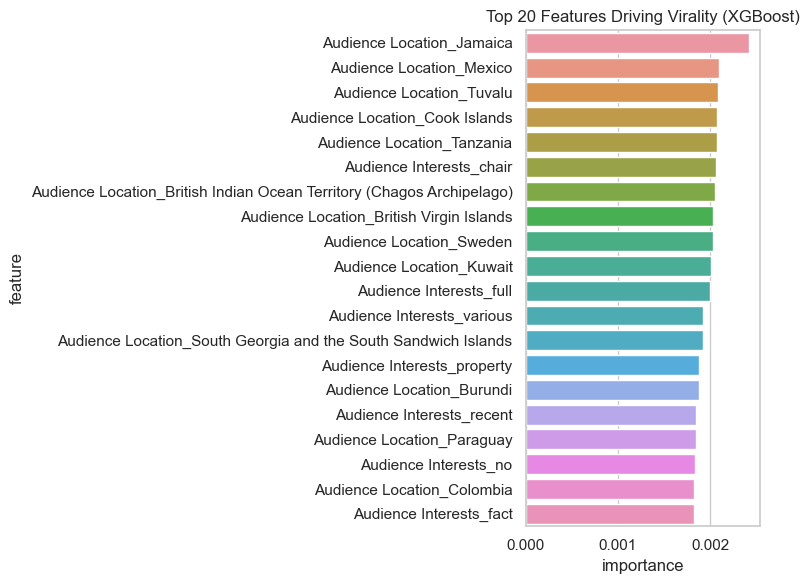

,feature,importance
117,Audience Location_Jamaica,0.002416
148,Audience Location_Mexico,0.002094
235,Audience Location_Tuvalu,0.002082
60,Audience Location_Cook Islands,0.002077
224,Audience Location_Tanzania,0.002070
404,Audience Interests_chair,0.002068
40,Audience Location_British Indian Ocean Territo...,0.002055
41,Audience Location_British Virgin Islands,0.002032
219,Audience Location_Sweden,0.002029
125,Audience Location_Kuwait,0.002010


In [22]:
# Chunk 10 — Interpret Best Model

if not results_df.empty:
    best_name = results_df.iloc[0]["Model"]
    print("[INFO] Selected best model:", best_name)

    best_model = models[best_name]
    # get feature names from preprocessor
    ohe = best_model.named_steps["pre"].named_transformers_["cat"]
    cat_feature_names = list(ohe.get_feature_names_out(use_cat))
    all_feature_names = cat_feature_names + use_num

    clf = best_model.named_steps["clf"]
    importances = getattr(clf, "feature_importances_", None)

    if importances is not None:
        imp_df = pd.DataFrame({
            "feature": all_feature_names,
            "importance": importances
        }).sort_values("importance", ascending=False).head(20)

        plt.figure(figsize=(8,6))
        sns.barplot(data=imp_df, x="importance", y="feature")
        plt.title(f"Top 20 Features Driving Virality ({best_name})")
        plt.tight_layout()
        plt.show()

        display(imp_df)
    else:
        print("[WARN] Best model does not expose feature_importances_.")
else:
    print("[WARN] No model results to interpret.")
